# Part 1: Preprocess pipeline

In [30]:
# import modules for first part:
import pandas as pd
import pandas_profiling
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score


In [2]:
 
def removing_columns(df):
    '''
    remove columns with 0 variance
    or more than 90% missing values:
    they are 4 columns in the train dataset
    '''
    df1=df.drop(['STDs:cervical condylomatosis','STDs:AIDS',
                'STDs: Time since first diagnosis','STDs: Time since last diagnosis'],axis=1)
    return df1

def fill_question_marks(df):
    df = df.replace('?', np.NaN)
    return df

def convert_to_numeric(df):
    '''
    convert all columns into numeric
    ''' 
    cols = df.columns
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    return df

def preprocess(df_train, df_test, df_validate):
    
    '''
    Apply the other functions and impute the null values with SimpleImputer.
    After convert to numeric all the columns will be numeric
    as the objects were actually numeric columns as strings
    '''
    
    df_train=removing_columns(df_train)
    df_train=fill_question_marks(df_train)
    df_train=convert_to_numeric(df_train)
 
    df_test=removing_columns(df_test)
    df_test=fill_question_marks(df_test)
    df_test=convert_to_numeric(df_test)

    df_validate=removing_columns(df_validate)
    df_validate=fill_question_marks(df_validate)
    df_validate=convert_to_numeric(df_validate)
    
    #impute with the median of train
    imputer = SimpleImputer(strategy="most_frequent")
    np_train = imputer.fit_transform(df_train)
    np_test = imputer.transform(df_test)
    np_validate = imputer.transform(df_validate)
    
    # convert np arrays to DataFrame again to manipulate them
    df_train = pd.DataFrame(np_train, columns=df_train.columns)
    df_test = pd.DataFrame(np_test, columns=df_train.columns)
    df_validate = pd.DataFrame(np_validate, columns=df_train.columns)
    
    #apply standard scaler to true numerical columns
    #copy the df:
    df_scaled_train = df_train.copy()
    df_scaled_test = df_test.copy()
    df_scaled_validate = df_validate.copy()
    
    col_names = ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies',
                'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives (years)', 'IUD (years)',
                'STDs (number)']
    
    #copy the columns to scale in a df
    features_train = df_scaled_train[col_names]
    features_test = df_scaled_test[col_names]
    features_validate = df_scaled_validate[col_names]
    
    #initialize scaler
    scaler = StandardScaler()
    
    #fit transform and transform the df with only the columns to scale
    features_train =scaler.fit_transform(features_train.values)
    features_test = scaler.transform(features_test.values)
    features_validate = scaler.transform(features_validate.values)
    
    #addign the results to the initial df (the copies one):
    df_scaled_train[col_names] = features_train
    df_scaled_test[col_names] = features_test
    df_scaled_validate[col_names] = features_validate

    
    return df_scaled_train, df_scaled_test, df_scaled_validate
    


In [3]:
#load the data
df1=pd.read_csv("../Data/kag_risk_factors_cervical_cancer.csv")

In [4]:
#divive the data in X and Y
X = df1.drop(columns="Biopsy")
y = df1["Biopsy"]


#spliting the validation data
from sklearn.model_selection import train_test_split
X_t, X_validate, y_t, y_validate = train_test_split(X, y, test_size=0.1, random_state=0)

# splitting the test and train data
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.15, random_state=0)

In [5]:
#save a profile of the X_train data. Previous exploration has already been performed
#get a description of the features:
profile = pandas_profiling.ProfileReport(X_train, title="Cervix cancer risk Data profiling")
profile.to_file("../Data/Cervix_cancer_data_profiling_report.html")

In [6]:
#Apply preprocess function  to all the X files:
#(remove unnecessary columns, replace question marks for Nan, convert to numeric and apply simple imputer)
X_train_ready, X_test_ready, X_validate_ready=preprocess(X_train, X_test, X_validate)

In [7]:
#save a profile of the X_train data after processing

profile = pandas_profiling.ProfileReport(X_train_ready, title="Post processing Cervix cancer risk Data profiling")
profile.to_file("../Data/Cervix_cancer_data_profiling_report_post_processing.html")

In [8]:
# Look at the cleaned dataframe first rows:
X_train_ready.head(2)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology
0,-1.531373,-0.302480,-1.064614,-0.836137,0.0,-0.307318,-0.208218,0.0,-0.556973,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.237878,1.427985,-0.001620,2.657531,1.0,-0.004815,0.325027,1.0,-0.412462,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
X_test_ready.head(2)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology
0,-1.413423,0.851163,-1.064614,-0.836137,1.0,-0.068558,-0.167199,1.0,-0.533851,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.535328,-0.302480,-0.001620,0.561330,0.0,-0.307318,-0.208218,1.0,4.934456,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
X_validate_ready.head(2)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology
0,0.355828,-0.302480,-0.001620,-0.836137,0.0,-0.307318,-0.208218,1.0,-0.267950,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.889179,0.851163,-0.355952,0.561330,1.0,6.377968,2.663100,0.0,-0.556973,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#save them in a csv file:

X_train_ready.to_csv("../Data/X_train_preprocessed.csv", index =None)
X_test_ready.to_csv("../Data/X_test_preprocessed.csv", index =None)
X_validate_ready.to_csv("../Data/X_validate_preprocessed.csv", index =None)
y_train.to_csv("../Data/y_train_preprocessed.csv", index =None)
y_test.to_csv("../Data/y_test_preprocessed.csv", index =None)
y_validate.to_csv("../Data/y_validate_preprocessed.csv", index =None)

## Part 1.2 : Predicting with Logistic Regression

In [12]:
#Use LogisticRegression to be sure that the data is formated correctly
#and that LR is not a good prediction method
print(f"Dataset was not very large. The train dataset has {len(y_train)} rows, the test {len(y_test)}, and the validation {len(y_validate)}")


Dataset was not very large. The train dataset has 656 rows, the test 116, and the validation 86


In [25]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [18]:
reg = LogisticRegression().fit(X_train_ready, y_train)
reg.score(X_train_ready, y_train)

0.975609756097561

In [19]:
y_pred=reg.predict(X_test_ready)

In [21]:
reg.score(X_test_ready, y_test)

0.9310344827586207

In [22]:
reg.score(X_validate_ready, y_validate)

0.9302325581395349

LR seems to be a great model, but since we know we have imbalanced data, we'll look at the confussion matrix:

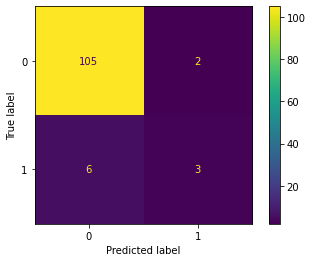

In [27]:
y_pred=reg.predict(X_test_ready)
y_pred_val=reg.predict(X_validate_ready)
cm_test = confusion_matrix(y_test, y_pred)
cm_val = confusion_matrix(y_validate, y_pred_val)

cm_display = ConfusionMatrixDisplay(cm_test).plot()


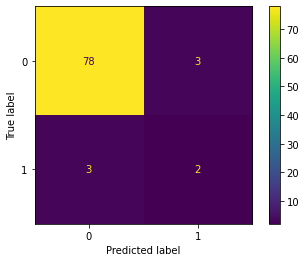

In [28]:
cm_display = ConfusionMatrixDisplay(cm_val).plot()

In [31]:
recall_score(y_test, y_pred)

0.3333333333333333

In [32]:
recall_score(y_validate, y_pred_val)

0.4

Sensitivity or Recall (Cancer diagnosis/ Toal cancer cases) is below 50% in the test and the validate subsets (Cancer dx/True cancer, Test: 3/9, Val:2/5 ).

It is worse than what we could accomplish by chance (33% and 40% v 50%)
LR is not a good predictor of positive cases in this imbalanced dataset.

Let's try some more advanced models in "cervix_project_2_Model_design1" notebook